# CSCE 5210 Fundamentals of AI Project - 3 (MDP)

## Submitted by:
Ashwini Sharma (<ashwinisharma@my.unt.edu>)


###Assumptions


In R1, living reward of -0.1 generates a utility matrix where cell (7,0) is having negative value and other cells around it are more negative, because of which bot is not able to move forward from start position.


I have made some simplifications and used a different local reward as 0.1 (positive value) which resolved the issue.
Main reason was, at start (0,7) #steps required to reach the goal are 11 while the nearby cells need only 10. which makes recharge probability high for S and a bit lower for nearby cells. On the contrary, movement with 1-recharge_probabilty is more at nearby cells which have negative values due to living reward of -0.1; will produce more negative in nearby cells. Hence, making the living reward to a positive low value resolves the issue.




living reward = 0.1




discount = .9




epsilon = 0.001




stops at epsilon delta or 100 iterations


at some places, hole and goal's -1 and +1 reward influence is controlled while calculating utility matrix, which helps in transition,


Recharge probability is considered in R1, R2 & R3.
R4 has a dedicated recharge station so recharge probability is not considered. Just added a recharge station in one cell with reward -0.2 because of which this cell is getting avoided in utility matrix and policy.

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#recharge probability function

def recharge_probability(steps_req):
  return 1/(1+10*(math.exp(-steps_req)))

#manhattan distance function
def manhattan_distance(point1, point2):
  distance = 0
  for x1, x2 in zip(point1, point2):
    difference = x2 - x1
    absolute_diff = abs(difference)
    distance += absolute_diff
  return distance

In [ ]:
#environment map & variables

custom_map = [['F','F','F','F','C'], ['F','F','H','F','G'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['S','F','F','F','F']]

global matrix_size
matrix_size = [8,5]

global actions_allowed
actions_allowed = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

global possible_dir_list
possible_dir_list = ['LEFT', 'DOWN', 'RIGHT', 'UP']

global obs
obs = matrix_size[0] * matrix_size[1]


In [ ]:
#utility matrix functions & calculations

def eval_state_action_map(V, s, a, dict_state, prob, gamma=0.9):
    sum_val = np.sum([((1-prob)*p) * V[next_s] for p, next_s, rew, _ in dict_state[a]])
    return sum_val


def value_iteration_map(epsiln, numobs, dict_state, dir_states, V, dest_loc):
    it = 0
    st = 1

    while True:
        delta = 0
        V_ref = V.copy()
        for s in range(numobs):
            x_ax = math.floor(s/5)
            y_ax = s%5
            tup_cur_loc = tuple(map(int, (x_ax, y_ax)))
            steps = manhattan_distance(tup_cur_loc, dest_loc)
            rech_prob = recharge_probability(steps)
            rew_liv = 0.1
            gamma=0.9
            old_v = V[s]
            if len(dir_states[s]) > 0:
              V[s] = rew_liv + gamma * np.max([eval_state_action_map(V_ref, s, a, dict_state[s], rech_prob) for a in dir_states[s]]) #Get the Bellman updated value for all actions and choose the action which gives the maximum value

            delta = max(delta, np.abs(old_v - V[s]))
            st = st + 1

        if delta < epsiln:
            break
        elif it > 100:
          break
        else:
            print('Iteration Number:', it, ' Delta Value:', np.round(delta, 5))
        it += 1

    return V


In [ ]:
#start to can utility calculations
def eval_start_to_can(map_init):
  custom_map_can = map_init
  problem_map_can = np.array(custom_map_can)

  movement_matrix_can = np.zeros(matrix_size, dtype=object)
  allowed_positions_can = 0
  pos_direction_can = 'dir'
  direction_list_can = []
  state_dict_can = {}
  movement_dict_can = {}
  move_direction_dict_can = {}
  v_space_can = np.zeros(obs)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      dir_dict_can = {}
      state_pos_can = (x*matrix_size[1])+y
      allowed_positions_can = 0
      pos_direction_can = 'Direction'
      direction_list_can = []
      direction_num_list_can = []

      if y-1 >= 0:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',LEFT')
        direction_list_can.append('LEFT')
        direction_num_list_can.append(0)

      if y+1 < matrix_size[1]:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',RIGHT')
        direction_list_can.append('RIGHT')
        direction_num_list_can.append(2)

      if x-1 >= 0:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',UP')
        direction_list_can.append('UP')
        direction_num_list_can.append(3)

      if x+1 < matrix_size[0]:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',DOWN')
        direction_list_can.append('DOWN')
        direction_num_list_can.append(1)

      pos_direction_can += str(',' + str(allowed_positions_can))
      if problem_map_can[x][y] == 'H' or problem_map_can[x][y] == 'C' or problem_map_can[x][y] == 'G':
        movement_matrix_can[x][y] = 0
        movement_dict_can[state_pos_can] = []
        move_direction_dict_can[state_pos_can] = []
      else:
       movement_matrix_can[x][y] = pos_direction_can
       movement_dict_can[state_pos_can] = direction_list_can
       move_direction_dict_can[state_pos_can] = direction_num_list_can

      probability_used_can = 0.0
      recharge_prob_can = 0.0
      next_pos_can = [x, y]
      reward_can = 0.0
      terminates_can = False

      for z in range(len(direction_list_can)):
        dir_list_can = []
        for c in range(len(direction_list_can)):

          if direction_list_can[c] == 'LEFT':
            a=x
            b=y-1
            if b < 0:
              b = y
          elif direction_list_can[c] == 'RIGHT':
            a=x
            b=y+1
            if b >= matrix_size[1]:
              b = y
          elif direction_list_can[c] == 'UP':
            a=x-1
            b=y
            if a < 0:
              a = x
          elif direction_list_can[c] == 'DOWN':
            a=x+1
            b=y
            if a >= matrix_size[0]:
              a = x
          else:
            a=x
            b=y


          if problem_map_can[x][y] == 'H' or problem_map_can[x][y] == 'C' or problem_map_can[x][y] == 'G':
            probability_used_can = 1.0 - recharge_prob_can
            next_pos_can = [x, y]
            reward_can = 0.0
            if problem_map_can[x][y] == 'C':
              reward_can = 10.0
              v_space_can[state_pos_can] = 10.0

            if problem_map_can[x][y] == 'G':
              v_space_can[state_pos_can] = 0.2

            if problem_map_can[x][y] == 'H':
              v_space_can[state_pos_can] = -1.0
              reward_can = -1.0

            terminates_can = True

          elif direction_list_can[z] == direction_list_can[c]:
            probability_used_can = (1-recharge_prob_can)*0.8
            next_pos_can = [a, b]
            reward_can = 0.0
            terminates_can = False
            if problem_map_can[a][b] == 'C' or problem_map_can[a][b] == 'H':
              if problem_map_can[a][b] == 'C':
                reward_can = 10.0
              else:
                reward_can = -1.0
              terminates_can = True

          else:
            probability_used_can = ((1-recharge_prob_can)*0.2)/(len(direction_list_can)-1)
            next_pos_can = [a, b]
            reward_can = 0.0
            terminates_can = False
            if problem_map_can[a][b] == 'C' or problem_map_can[a][b] == 'H':
              if problem_map_can[a][b] == 'C':
                reward_can = 10.0
              else:
                reward_can = -1.0
              terminates_can = True

          act_next_pos_can = (next_pos_can[0]*matrix_size[1])+next_pos_can[1]
          tuple_in_can = (probability_used_can, act_next_pos_can, reward_can, terminates_can)
          dir_list_can.append(tuple_in_can)

        dict_key_can = actions_allowed[direction_list_can[z]]
        dir_dict_can[dict_key_can] = dir_list_can

    #append
      state_dict_can[state_pos_can] = dir_dict_can

  probability_intended_can = 0.8
  probability_rest_can = 0.2

  #action_space
  nA = 4

  #observation_space (matrix x*y)
  nS = matrix_size[0] * matrix_size[1]

  print("observation_space: " + str(nS))
  print("v_space: " + str(v_space_can))

  epsn_can = .001

  loc_can = tuple(map(tuple, np.argwhere(problem_map_can == 'C')))
  can_location = loc_can[0]

  V_can = value_iteration_map(epsn_can, nS, state_dict_can, move_direction_dict_can, v_space_can, can_location)

  np.set_printoptions(formatter={'float_kind':'{:f}'.format})


  #Policy from start to can
  vtable_val_max_can = V_can.reshape(matrix_size[0],matrix_size[1]).copy()
  v_test_can = V_can.reshape(matrix_size[0],matrix_size[1]).copy()
  vtable_best_action_can = np.argmax(V_can)
  directions_can = {"LEFT": "←", "DOWN": "↓", "RIGHT": "→", "UP": "↑"}
  directions_num_can = {"LEFT": "0", "DOWN": "1", "RIGHT": "2", "UP": "3"}

  vtable_directions_can = np.empty(vtable_val_max_can.shape, dtype=str)
  value_policy_can = np.empty(vtable_val_max_can.shape, dtype=str)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      idx = (x*matrix_size[1]) + y
      for act in movement_dict_can[idx]:
        val_can = -1
        if act == "RIGHT" and problem_map_can[x][y+1] != 'G':
          val_can = v_test_can[x, y+1]
        elif act == "LEFT" and problem_map_can[x][y-1] != 'G':
          val_can = v_test_can[x, y-1]
        elif act == "UP" and problem_map_can[x-1][y] != 'G':
          val_can = v_test_can[x-1, y]
        elif act == "DOWN" and problem_map_can[x+1][y] != 'G':
          val_can = v_test_can[x+1, y]

        if val_can > vtable_val_max_can[x, y]:
          vtable_val_max_can[x, y] = val_can
          vtable_directions_can[x, y] = directions_can[act]
          value_policy_can[x, y] = directions_num_can[act]

  #print(vtable_directions_can)
  return state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can

In [ ]:
#can pickup to can drop utility calculations
def eval_can_to_goal(map_init):
  custom_map_goal = custom_map
  problem_map_goal = np.array(custom_map_goal)

  movement_matrix_goal = np.zeros(matrix_size, dtype=object)
  allowed_positions_goal = 0
  pos_direction_goal = 'dir'
  direction_list_goal = []
  state_dict_goal = {}
  movement_dict_goal = {}
  move_direction_dict_goal = {}
  v_space_goal = np.zeros(obs)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      dir_dict_goal = {}
      state_pos_goal = (x*matrix_size[1])+y
      allowed_positions_goal = 0
      pos_direction_goal = 'Direction'
      direction_list_goal = []
      direction_num_list_goal = []

      if y-1 >= 0:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',LEFT')
        direction_list_goal.append('LEFT')
        direction_num_list_goal.append(0)

      if y+1 < matrix_size[1]:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',RIGHT')
        direction_list_goal.append('RIGHT')
        direction_num_list_goal.append(2)

      if x-1 >= 0:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',UP')
        direction_list_goal.append('UP')
        direction_num_list_goal.append(3)

      if x+1 < matrix_size[0]:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',DOWN')
        direction_list_goal.append('DOWN')
        direction_num_list_goal.append(1)

      pos_direction_goal += str(',' + str(allowed_positions_goal))
      if problem_map_goal[x][y] == 'H' or problem_map_goal[x][y] == 'G':
        movement_matrix_goal[x][y] = 0
        movement_dict_goal[state_pos_goal] = []
        move_direction_dict_goal[state_pos_goal] = []

      else:
        movement_matrix_goal[x][y] = pos_direction_goal
        movement_dict_goal[state_pos_goal] = direction_list_goal
        move_direction_dict_goal[state_pos_goal] = direction_num_list_goal

      probability_used_goal = 0.0
      recharge_prob_goal = 0.0
      next_pos_goal = [x, y]
      reward_goal = 0.0
      terminates_goal = False

      for z in range(len(direction_list_goal)):
        dir_list_goal = []
        for c in range(len(direction_list_goal)):

          if direction_list_goal[c] == 'LEFT':
            a=x
            b=y-1
            if b < 0:
              b = y
          elif direction_list_goal[c] == 'RIGHT':
            a=x
            b=y+1
            if b >= matrix_size[1]:
              b = y
          elif direction_list_goal[c] == 'UP':
            a=x-1
            b=y
            if a < 0:
              a = x
          elif direction_list_goal[c] == 'DOWN':
            a=x+1
            b=y
            if a >= matrix_size[0]:
              a = x
          else:
            a=x
            b=y


          if problem_map_goal[x][y] == 'H' or problem_map_goal[x][y] == 'G':
            probability_used_goal = 1.0 - recharge_prob_goal
            next_pos_goal = [x, y]
            reward_goal = 0.0

            if problem_map_goal[x][y] == 'G':
              v_space_goal[state_pos_goal] = 1.0
              reward_goal = 1.0

            if problem_map_goal[x][y] == 'H':
              v_space_goal[state_pos_goal] = -0.5
              reward_goal = -1.0

            terminates_goal = True

          elif direction_list_goal[z] == direction_list_goal[c]:
            probability_used_goal = (1-recharge_prob_goal)*0.8
            next_pos_goal = [a, b]
            reward_goal = 0.0
            terminates_goal = False
            if problem_map_goal[a][b] == 'H' or problem_map_goal[a][b] == 'G':
              reward_goal = -1.0
              terminates_goal = True
              if problem_map_goal[a][b] == 'G':
                reward_goal = 1.0

          else:
            probability_used_goal = ((1-recharge_prob_goal)*0.2)/(len(direction_list_goal)-1)
            next_pos_goal = [a, b]
            reward_goal = 0.0
            terminates_goal = False
            if problem_map_goal[a][b] == 'H' or problem_map_goal[a][b] == 'G':
              reward_goal = -1.0
              terminates_goal = True
              if problem_map_goal[a][b] == 'G':
                reward = 1.0

          act_next_pos_goal = (next_pos_goal[0]*matrix_size[1])+next_pos_goal[1]
          tuple_in_goal = (probability_used_goal, act_next_pos_goal, reward_goal, terminates_goal)
          dir_list_goal.append(tuple_in_goal)

        dict_key_goal = actions_allowed[direction_list_goal[z]]
        dir_dict_goal[dict_key_goal] = dir_list_goal


      state_dict_goal[state_pos_goal] = dir_dict_goal

  probability_intended_goal = 0.8
  probability_rest_goal = 0.2

  #action_space
  nA = 4

  #observation_space
  nS = matrix_size[0] * matrix_size[1]

  epsn_goal = .001

  loc_goal = tuple(map(tuple, np.argwhere(problem_map_goal == 'G')))
  goal_location = loc_goal[0]

  V_goal = value_iteration_map(epsn_goal, nS, state_dict_goal, move_direction_dict_goal, v_space_goal, goal_location)

  np.set_printoptions(formatter={'float_kind':'{:f}'.format})


  #Policy from can to goal
  vtable_val_max_goal = V_goal.reshape(matrix_size[0],matrix_size[1]).copy()
  v_test_goal = V_goal.reshape(matrix_size[0],matrix_size[1]).copy()
  directions_goal = {"LEFT": "←", "DOWN": "↓", "RIGHT": "→", "UP": "↑"}
  directions_num_goal = {"LEFT": "0", "DOWN": "1", "RIGHT": "2", "UP": "3"}
  vtable_directions_goal = np.empty(vtable_val_max_goal.shape, dtype=str)
  value_policy_goal = np.empty(vtable_val_max_goal.shape, dtype=str)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      idx = (x*matrix_size[1]) + y
      for act in movement_dict_goal[idx]:
        val_goal = -1
        if act == "RIGHT":
          val_goal = v_test_goal[x, y+1]
        elif act == "LEFT" :
          val_goal = v_test_goal[x, y-1]
        elif act == "UP":
          val_goal = v_test_goal[x-1, y]
        elif act == "DOWN":
          val_goal = v_test_goal[x+1, y]

        if val_goal > vtable_val_max_goal[x, y]:
          vtable_val_max_goal[x, y] = val_goal
          vtable_directions_goal[x, y] = directions_goal[act]
          value_policy_goal[x, y] = directions_num_goal[act]

  #print(vtable_directions_goal)
  return state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal

In [ ]:
def run_episodes_start_to_can(dict_state, V, dir_states, num_games, start_loc, start_pos, v_policy, v_max):
    tot_rew = 0
    state = start_loc
    misses = 0
    steps_list = []
    actions_allowed = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

    for _ in range(num_games):
        done = False
        steps=0
        print("starting from : " + str(start_pos))
        while not done:
            x_ax = math.floor(state/5)
            y_ax = state%5
            tup_cur_loc = list(map(int, (x_ax, y_ax)))

            old_v = V[state]
            action = 5
            act = actions_allowed

            if len(dir_states[state]) > 0:
              action = int(v_policy[x_ax][y_ax])

            act = actions_allowed[action]

            reward = -1
            if act == "RIGHT":
              reward = v_max[x_ax, y_ax+1]
              next_s = [x_ax, y_ax+1]
              if v_policy[x_ax, y_ax+1] == '':
                done = True
            elif act == "LEFT" :
              reward = v_max[x_ax, y_ax-1]
              next_s = [x_ax, y_ax-1]
              if v_policy[x_ax, y_ax-1] == '':
                done = True
            elif act == "UP":
              reward = v_max[x_ax-1, y_ax]
              next_s = [x_ax-1, y_ax]
              if v_policy[x_ax-1, y_ax] == '':
                done = True
            elif act == "DOWN":
              reward = v_max[x_ax+1, y_ax]
              next_s = [x_ax+1, y_ax]
              if v_policy[x_ax+1, y_ax] == '':
                done = True

            next_state = next_s[0]*5 + next_s[1]

            print("action taken: " + actions_allowed[action])

            state = next_state

            reward_loc = old_v

            tot_rew = tot_rew + reward

            steps+=1

            print("next_state: " + str(next_state) + ";  current reward: " + str(reward) + ";  completed: " + str(done) + ";  total reward: " + str(tot_rew)
             + ";  steps: " + str(steps))

            if done and reward == 10:
              steps_list.append(steps)
              state = start_loc
              print("---------- Reached to can ----------")
              break
            elif done and reward == -1:
              # print("You fell in a hole!")
              state = start_loc
              misses += 1
              print("next_state: " + str(next_state) + " reward: " + str(reward) + " done: " + str(done) + " tot_rew: " + str(tot_rew)
             + " steps: " + str(steps))
              break

    print('In %i games accumulated rewards of %i !'%(num_games, tot_rew))
    print('----------------------------------------------')
    print('step list: ', steps_list)
    print('Average steps taken to reach to the can are {:.0f}'.format(np.mean(steps_list)))
    print('{:.2f} % of the times, instead of Can, it reached to the hole'.format((misses/num_games) * 100))
    print('----------------------------------------------')

    return steps_list

In [ ]:
## run episode for can to goal
def run_episodes_can_to_goal(dict_state, V, dir_states, num_games, start_loc, start_pos, v_policy, v_max, steps_already_walked):
    tot_rew = 0
    state = start_loc
    misses = 0
    steps_list = []
    actions_allowed = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}
    lp_cnt = 0

    for _ in range(num_games):
        done = False
        steps=0
        print("starting from : " + str(start_pos))
        while not done:
            x_ax = math.floor(state/5)
            y_ax = state%5
            tup_cur_loc = list(map(int, (x_ax, y_ax)))
            old_v = V[state]
            action = 5
            act = actions_allowed

            if len(dir_states[state]) > 0:
              action = int(v_policy[x_ax][y_ax])

            act = actions_allowed[action]

            reward = -1
            if act == "RIGHT":
              reward = v_max[x_ax, y_ax+1]
              next_s = [x_ax, y_ax+1]
              if v_policy[x_ax, y_ax+1] == '':
                done = True
            elif act == "LEFT" :
              reward = v_max[x_ax, y_ax-1]
              next_s = [x_ax, y_ax-1]
              if v_policy[x_ax, y_ax-1] == '':
                done = True
            elif act == "UP":
              reward = v_max[x_ax-1, y_ax]
              next_s = [x_ax-1, y_ax]
              if v_policy[x_ax-1, y_ax] == '':
                done = True
            elif act == "DOWN":
              reward = v_max[x_ax+1, y_ax]
              next_s = [x_ax+1, y_ax]
              if v_policy[x_ax+1, y_ax] == '':
                done = True

            next_state = next_s[0]*5 + next_s[1]

            print("action taken: " + actions_allowed[action])

            state = next_state

            reward_loc = old_v

            tot_rew = tot_rew + reward

            steps+=1

            print("next_state: " + str(next_state) + ";  current reward: " + str(reward) + ";  completed: " + str(done) + ";  total reward: " + str(tot_rew)
             + ";  steps: " + str(steps))

            if done and reward == 1:
              tot_rew = tot_rew + reward
              state = start_loc
              print("---------- Reached to goal state ---------- ")
              tot_steps_e2e = steps_already_walked[lp_cnt] + steps
              print("---------- Complete count of steps from start to can and can to goal is: " + str(tot_steps_e2e))
              steps_list.append(tot_steps_e2e)
              lp_cnt+=1
              break
            elif done and reward == -1:
              tot_rew = tot_rew + reward
              # print("You fell in a hole!")
              state = start_loc
              misses += 1
              print("next_state: " + str(next_state) + " reward: " + str(reward) + " done: " + str(done) + " tot_rew: " + str(tot_rew)
             + " steps: " + str(steps))
              break

    print('In %i games accumulated rewards of %i !'%(num_games, tot_rew))
    print('----------------------------------------------')
    print('step list: ', steps_list)
    print('Average steps taken to reach to the Goal are {:.0f}'.format(np.mean(steps_list)))
    print('{:.2f} % of the times, instead of Goal, it reached to the hole'.format((misses/num_games) * 100))
    print('----------------------------------------------')

#R1 Output

[['F' 'F' 'F' 'F' 'C']
 ['F' 'F' 'H' 'F' 'G']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['S' 'F' 'F' 'F' 'F']]
observation_space: 40
v_space: [0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 -1.000000
 0.000000 0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
Iteration Number: 0  Delta Value: 5.76114
Iteration Number: 1  Delta Value: 2.3906
Iteration Number: 2  Delta Value: 0.56208
Iteration Number: 3  Delta Value: 0.20861
Iteration Number: 4  Delta Value: 0.05176
Iteration Number: 5  Delta Value: 0.02093
Iteration Number: 6  Delta Value: 0.00535
Iteration Number: 7  Delta Value: 0.00163
Iteration Number: 0  Delta Value: 0.66611
Iteration Number: 1  Delta Value: 0.313

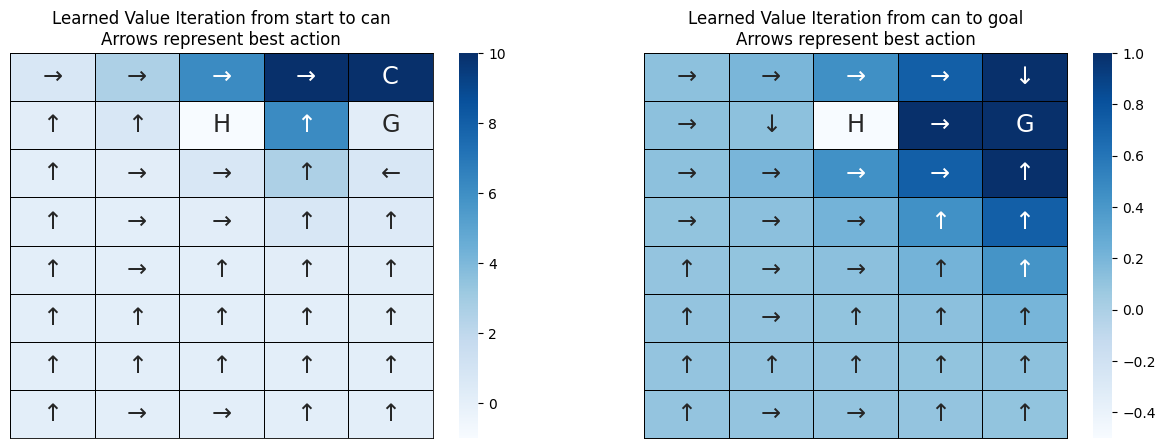

In [ ]:
#Policy call and plot

#define map
custom_map = [['F','F','F','F','C'], ['F','F','H','F','G'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['S','F','F','F','F']]
map_out = np.array(custom_map)
print(map_out)

#call start to can
state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can = eval_start_to_can(custom_map)

#call can to goal
state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal = eval_can_to_goal(custom_map)

print("Utility values from Start to Soda Can")
print(V_can.reshape((8,5)))

print('\nUtility values from Soda Can to Goal')
print(V_goal.reshape((8,5)))

problem_map = np.array(custom_map)
loc_start_annot = list(map(list, np.argwhere(problem_map == 'S')))[0]
loc_can_annot = list(map(list, np.argwhere(problem_map == 'C')))[0]
loc_goal_annot = list(map(list, np.argwhere(problem_map == 'G')))[0]
loc_hole_annot = list(map(list, np.argwhere(problem_map == 'H')))[0]

#vtable_directions_can[loc_start_annot[0], loc_start_annot[1]] = 'S'
vtable_directions_can[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_can[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_can[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for can
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.heatmap(
    vtable_val_max_can,
    annot=vtable_directions_can,
    fmt="",
    ax=ax[0],
    linewidths=0.6,
    xticklabels=[],
    yticklabels=[],
    cmap=sns.color_palette("Blues", as_cmap=True),
    linecolor="black",
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from start to can\nArrows represent best action")

for _, spine in ax[0].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.6)
  spine.set_color("black")


#vtable_directions_goal[loc_start_annot[0], loc_start_annot[1]] = 'S'
#vtable_directions_goal[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_goal[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_goal[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for goal
sns.heatmap(
    vtable_val_max_goal,
    annot=vtable_directions_goal,
    fmt="",
    ax=ax[1],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from can to goal\nArrows represent best action")

for _, spine in ax[1].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")

plt.show()

#R2 Output

In [ ]:
problem_map = np.array(custom_map)

loc_start = tuple(map(tuple, np.argwhere(problem_map == 'S')))
loc_can = tuple(map(tuple, np.argwhere(problem_map == 'C')))
loc_goal = tuple(map(tuple, np.argwhere(problem_map == 'G')))

start_pos = loc_start[0]
can_pos = loc_can[0]
goal_pos = loc_goal[0]

print("start_pos: " + str(start_pos))
print("can_pos: " + str(can_pos))
print("goal_pos: " + str(goal_pos))

num_episodes = 1
V_run_can = V_can.copy()
start_index = (start_pos[0]*matrix_size[1])+start_pos[1]
steps_req_manhattan = manhattan_distance(start_pos, can_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
steps_walked = run_episodes_start_to_can(state_dict_can, V_run_can, move_direction_dict_can, num_episodes, start_index, start_pos, value_policy_can, v_test_can)

print('\n------ Env reset, moving from soda can to goal')
print("Current Position: " + str(can_pos))
print("Goal Position: " + str(goal_pos))
V_run_goal = V_goal.copy()
can_index = (can_pos[0]*matrix_size[1])+can_pos[1]
steps_req_manhattan = manhattan_distance(can_pos, goal_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
run_episodes_can_to_goal(state_dict_goal, V_run_goal, move_direction_dict_goal, num_episodes, can_index, can_pos, value_policy_goal, v_test_goal, steps_walked)

start_pos: (7, 0)
can_pos: (0, 4)
goal_pos: (1, 4)
steps required as per manhattan distance: 11
starting from : (7, 0)
action taken: UP
next_state: 30;  current reward: 0.10004088289693852;  completed: False;  total reward: 0.10004088289693852;  steps: 1
action taken: UP
next_state: 25;  current reward: 0.10011123915121765;  completed: False;  total reward: 0.2001521220481562;  steps: 2
action taken: UP
next_state: 20;  current reward: 0.1003031903090626;  completed: False;  total reward: 0.3004553123572188;  steps: 3
action taken: UP
next_state: 15;  current reward: 0.10083088853980282;  completed: False;  total reward: 0.4012862008970216;  steps: 4
action taken: UP
next_state: 10;  current reward: 0.1023731518398356;  completed: False;  total reward: 0.5036593527368572;  steps: 5
action taken: UP
next_state: 5;  current reward: 0.11000472642059513;  completed: False;  total reward: 0.6136640791574524;  steps: 6
action taken: UP
next_state: 0;  current reward: 0.18543668933118912;  co

#R3 Output

###Episode 1 with Start as (5,1) & drop off as (2,4)

[['F' 'F' 'F' 'F' 'C']
 ['F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'G']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'S' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']]
observation_space: 40
v_space: [0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 -1.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
Iteration Number: 0  Delta Value: 5.77529
Iteration Number: 1  Delta Value: 2.59517
Iteration Number: 2  Delta Value: 0.59232
Iteration Number: 3  Delta Value: 0.17518
Iteration Number: 4  Delta Value: 0.04567
Iteration Number: 5  Delta Value: 0.01244
Iteration Number: 6  Delta Value: 0.00329
Iteration Number: 0  Delta Value: 0.66611
Iteration Number: 1  Delta Value: 0.30569
Iteration Number: 2  Delta Value: 0.07

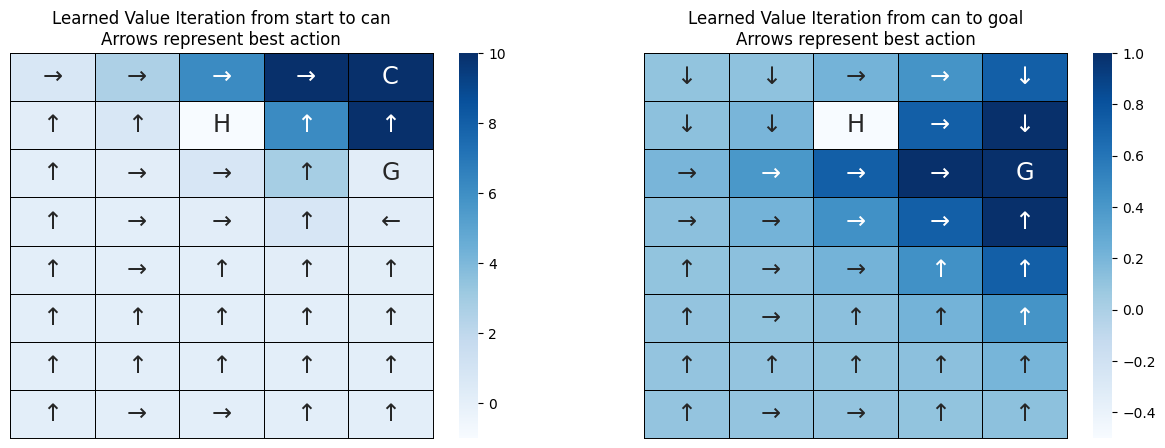



-------------- Running episodes
start_pos: (5, 1)
can_pos: (0, 4)
goal_pos: (2, 4)
steps required as per manhattan distance: 8
starting from : (5, 1)
action taken: UP
next_state: 21;  current reward: 0.10083028392128858;  completed: False;  total reward: 0.10083028392128858;  steps: 1
action taken: RIGHT
next_state: 22;  current reward: 0.10237068826332375;  completed: False;  total reward: 0.20320097218461233;  steps: 2
action taken: UP
next_state: 17;  current reward: 0.11016073847647252;  completed: False;  total reward: 0.31336171066108487;  steps: 3
action taken: RIGHT
next_state: 18;  current reward: 0.19178333956532942;  completed: False;  total reward: 0.5051450502264143;  steps: 4
action taken: UP
next_state: 13;  current reward: 0.7920407546223595;  completed: False;  total reward: 1.2971858048487737;  steps: 5
action taken: UP
next_state: 8;  current reward: 2.8448979383511146;  completed: False;  total reward: 4.142083743199889;  steps: 6
action taken: UP
next_state: 3;  

In [ ]:
#Policy call and plot

#define map
custom_map = [['F','F','F','F','C'], ['F','F','H','F','F'], ['F','F','F','F','G'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','S','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F']]
map_out = np.array(custom_map)
print(map_out)

#call start to can
state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can = eval_start_to_can(custom_map)

#call can to goal
state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal = eval_can_to_goal(custom_map)

print("Utility values from Start to Soda Can")
print(V_can.reshape((8,5)))

print('\nUtility values from Soda Can to Goal')
print(V_goal.reshape((8,5)))

problem_map = np.array(custom_map)
loc_start_annot = list(map(list, np.argwhere(problem_map == 'S')))[0]
loc_can_annot = list(map(list, np.argwhere(problem_map == 'C')))[0]
loc_goal_annot = list(map(list, np.argwhere(problem_map == 'G')))[0]
loc_hole_annot = list(map(list, np.argwhere(problem_map == 'H')))[0]

#vtable_directions_can[loc_start_annot[0], loc_start_annot[1]] = 'S'
vtable_directions_can[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_can[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_can[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for can
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.heatmap(
    vtable_val_max_can,
    annot=vtable_directions_can,
    fmt="",
    ax=ax[0],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from start to can\nArrows represent best action")

for _, spine in ax[0].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")


#vtable_directions_goal[loc_start_annot[0], loc_start_annot[1]] = 'S'
#vtable_directions_goal[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_goal[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_goal[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for goal
sns.heatmap(
    vtable_val_max_goal,
    annot=vtable_directions_goal,
    fmt="",
    ax=ax[1],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from can to goal\nArrows represent best action")

for _, spine in ax[1].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")

plt.show()


problem_map = np.array(custom_map)

loc_start = tuple(map(tuple, np.argwhere(problem_map == 'S')))
loc_can = tuple(map(tuple, np.argwhere(problem_map == 'C')))
loc_goal = tuple(map(tuple, np.argwhere(problem_map == 'G')))

start_pos = loc_start[0]
can_pos = loc_can[0]
goal_pos = loc_goal[0]

print('\n\n-------------- Running episodes')
print("start_pos: " + str(start_pos))
print("can_pos: " + str(can_pos))
print("goal_pos: " + str(goal_pos))

num_episodes = 1
V_run_can = V_can.copy()
start_index = (start_pos[0]*matrix_size[1])+start_pos[1]
steps_req_manhattan = manhattan_distance(start_pos, can_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
steps_walked = run_episodes_start_to_can(state_dict_can, V_run_can, move_direction_dict_can, num_episodes, start_index, start_pos, value_policy_can, v_test_can)

print('\n------ Env reset, moving from soda can to goal')
print("Current Position: " + str(can_pos))
print("Goal Position: " + str(goal_pos))
V_run_goal = V_goal.copy()
can_index = (can_pos[0]*matrix_size[1])+can_pos[1]
steps_req_manhattan = manhattan_distance(can_pos, goal_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
run_episodes_can_to_goal(state_dict_goal, V_run_goal, move_direction_dict_goal, num_episodes, can_index, can_pos, value_policy_goal, v_test_goal, steps_walked)

###Episode 2 with Start as (7,4) & drop off as (2,1)

[['F' 'F' 'F' 'F' 'C']
 ['F' 'F' 'H' 'F' 'F']
 ['F' 'G' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'S']]
observation_space: 40
v_space: [0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 -1.000000
 0.000000 0.000000 0.000000 0.200000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
Iteration Number: 0  Delta Value: 5.76114
Iteration Number: 1  Delta Value: 2.58766
Iteration Number: 2  Delta Value: 0.65694
Iteration Number: 3  Delta Value: 0.20973
Iteration Number: 4  Delta Value: 0.05446
Iteration Number: 5  Delta Value: 0.01687
Iteration Number: 6  Delta Value: 0.00441
Iteration Number: 7  Delta Value: 0.00134
Iteration Number: 0  Delta Value: 0.66611
Iteration Number: 1  Delta Value: 0.31

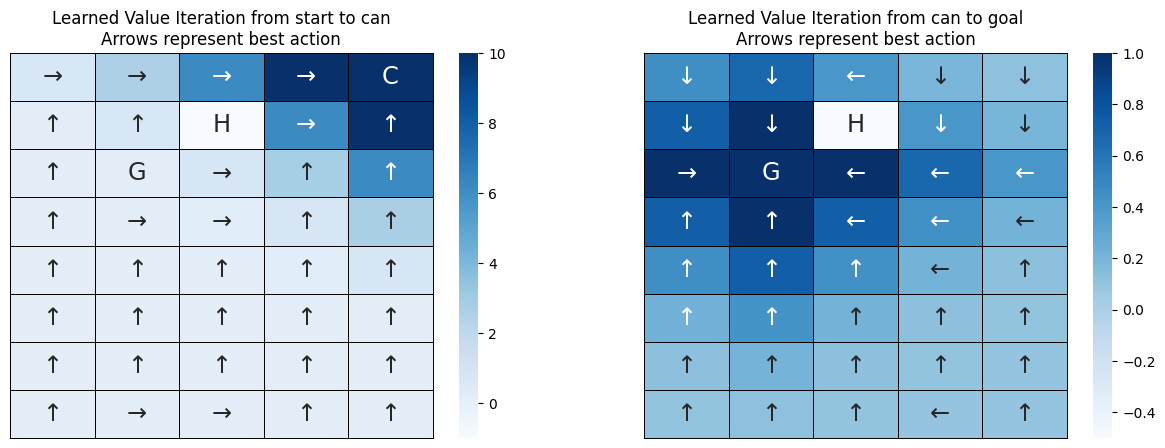



-------------- Running episodes
start_pos: (7, 4)
can_pos: (0, 4)
goal_pos: (2, 1)
steps required as per manhattan distance: 7
starting from : (7, 4)
action taken: UP
next_state: 34;  current reward: 0.10234948974599985;  completed: False;  total reward: 0.10234948974599985;  steps: 1
action taken: UP
next_state: 29;  current reward: 0.10972460039209625;  completed: False;  total reward: 0.21207409013809608;  steps: 2
action taken: UP
next_state: 24;  current reward: 0.1883692551782668;  completed: False;  total reward: 0.4004433453163629;  steps: 3
action taken: UP
next_state: 19;  current reward: 0.7656440246009192;  completed: False;  total reward: 1.166087369917282;  steps: 4
action taken: UP
next_state: 14;  current reward: 2.7324579292972055;  completed: False;  total reward: 3.8985452992144873;  steps: 5
action taken: UP
next_state: 9;  current reward: 6.15660047589002;  completed: False;  total reward: 10.055145775104506;  steps: 6
action taken: UP
next_state: 4;  current rew

In [ ]:
#Policy call and plot

#define map
custom_map = [['F','F','F','F','C'], ['F','F','H','F','F'], ['F','G','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','S']]
map_out = np.array(custom_map)
print(map_out)

#call start to can
state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can = eval_start_to_can(custom_map)

#call can to goal
state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal = eval_can_to_goal(custom_map)

print("Utility values from Start to Soda Can")
print(V_can.reshape((8,5)))

print('\nUtility values from Soda Can to Goal')
print(V_goal.reshape((8,5)))

problem_map = np.array(custom_map)
loc_start_annot = list(map(list, np.argwhere(problem_map == 'S')))[0]
loc_can_annot = list(map(list, np.argwhere(problem_map == 'C')))[0]
loc_goal_annot = list(map(list, np.argwhere(problem_map == 'G')))[0]
loc_hole_annot = list(map(list, np.argwhere(problem_map == 'H')))[0]

#vtable_directions_can[loc_start_annot[0], loc_start_annot[1]] = 'S'
vtable_directions_can[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_can[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_can[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for can
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.heatmap(
    vtable_val_max_can,
    annot=vtable_directions_can,
    fmt="",
    ax=ax[0],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from start to can\nArrows represent best action")

for _, spine in ax[0].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")


#vtable_directions_goal[loc_start_annot[0], loc_start_annot[1]] = 'S'
#vtable_directions_goal[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_goal[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_goal[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for goal
sns.heatmap(
    vtable_val_max_goal,
    annot=vtable_directions_goal,
    fmt="",
    ax=ax[1],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from can to goal\nArrows represent best action")

for _, spine in ax[1].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")

plt.show()


problem_map = np.array(custom_map)

loc_start = tuple(map(tuple, np.argwhere(problem_map == 'S')))
loc_can = tuple(map(tuple, np.argwhere(problem_map == 'C')))
loc_goal = tuple(map(tuple, np.argwhere(problem_map == 'G')))

start_pos = loc_start[0]
can_pos = loc_can[0]
goal_pos = loc_goal[0]

print('\n\n-------------- Running episodes')
print("start_pos: " + str(start_pos))
print("can_pos: " + str(can_pos))
print("goal_pos: " + str(goal_pos))

num_episodes = 1
V_run_can = V_can.copy()
start_index = (start_pos[0]*matrix_size[1])+start_pos[1]
steps_req_manhattan = manhattan_distance(start_pos, can_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
steps_walked = run_episodes_start_to_can(state_dict_can, V_run_can, move_direction_dict_can, num_episodes, start_index, start_pos, value_policy_can, v_test_can)

print('\n------ Env reset, moving from soda can to goal')
print("Current Position: " + str(can_pos))
print("Goal Position: " + str(goal_pos))
V_run_goal = V_goal.copy()
can_index = (can_pos[0]*matrix_size[1])+can_pos[1]
steps_req_manhattan = manhattan_distance(can_pos, goal_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
run_episodes_can_to_goal(state_dict_goal, V_run_goal, move_direction_dict_goal, num_episodes, can_index, can_pos, value_policy_goal, v_test_goal, steps_walked)

###Episode 3 with Start as (2,2) & drop off as (6,1)

[['F' 'F' 'F' 'F' 'C']
 ['F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'S' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'G' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']]
observation_space: 40
v_space: [0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 -1.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
Iteration Number: 0  Delta Value: 5.76114
Iteration Number: 1  Delta Value: 2.58766
Iteration Number: 2  Delta Value: 0.66002
Iteration Number: 3  Delta Value: 0.20989
Iteration Number: 4  Delta Value: 0.0545
Iteration Number: 5  Delta Value: 0.01689
Iteration Number: 6  Delta Value: 0.00441
Iteration Number: 7  Delta Value: 0.00134
Iteration Number: 0  Delta Value: 0.66611
Iteration Number: 1  Delta Value: 0.344

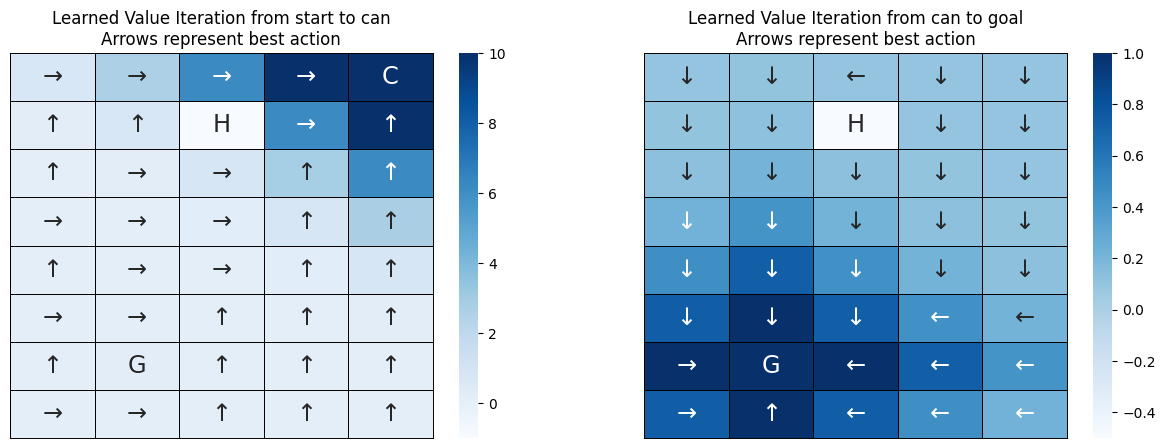



-------------- Running episodes
start_pos: (2, 2)
can_pos: (0, 4)
goal_pos: (6, 1)
steps required as per manhattan distance: 4
starting from : (2, 2)
action taken: RIGHT
next_state: 13;  current reward: 0.8457551367384044;  completed: False;  total reward: 0.8457551367384044;  steps: 1
action taken: UP
next_state: 8;  current reward: 2.8559392068094667;  completed: False;  total reward: 3.701694343547871;  steps: 2
action taken: RIGHT
next_state: 9;  current reward: 6.156600355404534;  completed: False;  total reward: 9.858294698952406;  steps: 3
action taken: UP
next_state: 4;  current reward: 10.0;  completed: True;  total reward: 19.858294698952406;  steps: 4
---------- Reached to can ----------
In 1 games accumulated rewards of 19 !
----------------------------------------------
step list:  [4]
Average steps taken to reach to the can are 4
0.00 % of the times, instead of Can, it reached to the hole
----------------------------------------------

------ Env reset, moving from soda

In [ ]:
#Policy call and plot

#define map
custom_map = [['F','F','F','F','C'], ['F','F','H','F','F'], ['F','F','S','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','G','F','F','F'], ['F','F','F','F','F']]
map_out = np.array(custom_map)
print(map_out)

#call start to can
state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can = eval_start_to_can(custom_map)

#call can to goal
state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal = eval_can_to_goal(custom_map)

print("Utility values from Start to Soda Can")
print(V_can.reshape((8,5)))

print('\nUtility values from Soda Can to Goal')
print(V_goal.reshape((8,5)))

problem_map = np.array(custom_map)
loc_start_annot = list(map(list, np.argwhere(problem_map == 'S')))[0]
loc_can_annot = list(map(list, np.argwhere(problem_map == 'C')))[0]
loc_goal_annot = list(map(list, np.argwhere(problem_map == 'G')))[0]
loc_hole_annot = list(map(list, np.argwhere(problem_map == 'H')))[0]

#vtable_directions_can[loc_start_annot[0], loc_start_annot[1]] = 'S'
vtable_directions_can[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_can[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_can[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for can
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.heatmap(
    vtable_val_max_can,
    annot=vtable_directions_can,
    fmt="",
    ax=ax[0],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from start to can\nArrows represent best action")

for _, spine in ax[0].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")


#vtable_directions_goal[loc_start_annot[0], loc_start_annot[1]] = 'S'
#vtable_directions_goal[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_goal[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_goal[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for goal
sns.heatmap(
    vtable_val_max_goal,
    annot=vtable_directions_goal,
    fmt="",
    ax=ax[1],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from can to goal\nArrows represent best action")

for _, spine in ax[1].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")

plt.show()


problem_map = np.array(custom_map)

loc_start = tuple(map(tuple, np.argwhere(problem_map == 'S')))
loc_can = tuple(map(tuple, np.argwhere(problem_map == 'C')))
loc_goal = tuple(map(tuple, np.argwhere(problem_map == 'G')))

start_pos = loc_start[0]
can_pos = loc_can[0]
goal_pos = loc_goal[0]

print('\n\n-------------- Running episodes')
print("start_pos: " + str(start_pos))
print("can_pos: " + str(can_pos))
print("goal_pos: " + str(goal_pos))

num_episodes = 1
V_run_can = V_can.copy()
start_index = (start_pos[0]*matrix_size[1])+start_pos[1]
steps_req_manhattan = manhattan_distance(start_pos, can_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
steps_walked = run_episodes_start_to_can(state_dict_can, V_run_can, move_direction_dict_can, num_episodes, start_index, start_pos, value_policy_can, v_test_can)

print('\n------ Env reset, moving from soda can to goal')
print("Current Position: " + str(can_pos))
print("Goal Position: " + str(goal_pos))
V_run_goal = V_goal.copy()
can_index = (can_pos[0]*matrix_size[1])+can_pos[1]
steps_req_manhattan = manhattan_distance(can_pos, goal_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
run_episodes_can_to_goal(state_dict_goal, V_run_goal, move_direction_dict_goal, num_episodes, can_index, can_pos, value_policy_goal, v_test_goal, steps_walked)

###Episode 4 with Start as (0,0) & drop off as (7,4)

[['S' 'F' 'F' 'F' 'C']
 ['F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'G']]
observation_space: 40
v_space: [0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 -1.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.200000]
Iteration Number: 0  Delta Value: 5.76114
Iteration Number: 1  Delta Value: 2.58766
Iteration Number: 2  Delta Value: 0.66002
Iteration Number: 3  Delta Value: 0.20989
Iteration Number: 4  Delta Value: 0.0545
Iteration Number: 5  Delta Value: 0.01689
Iteration Number: 6  Delta Value: 0.00441
Iteration Number: 7  Delta Value: 0.00134
Iteration Number: 0  Delta Value: 0.66611
Iteration Number: 1  Delta Value: 0.305

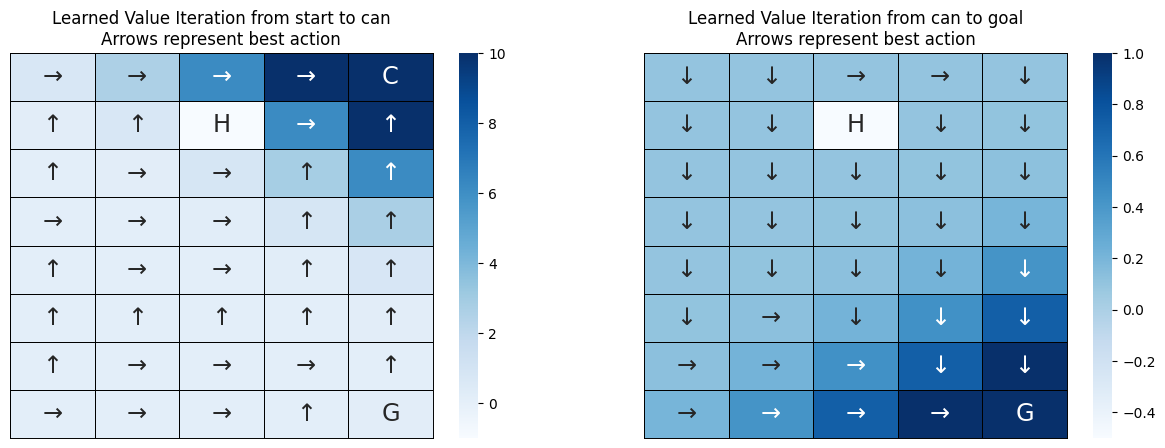



-------------- Running episodes
start_pos: (0, 0)
can_pos: (0, 4)
goal_pos: (7, 4)
steps required as per manhattan distance: 4
starting from : (0, 0)
action taken: RIGHT
next_state: 1;  current reward: 0.7408606761712392;  completed: False;  total reward: 0.7408606761712392;  steps: 1
action taken: RIGHT
next_state: 2;  current reward: 2.632754918059855;  completed: False;  total reward: 3.373615594231094;  steps: 2
action taken: RIGHT
next_state: 3;  current reward: 6.1495451109181145;  completed: False;  total reward: 9.523160705149209;  steps: 3
action taken: RIGHT
next_state: 4;  current reward: 10.0;  completed: True;  total reward: 19.52316070514921;  steps: 4
---------- Reached to can ----------
In 1 games accumulated rewards of 19 !
----------------------------------------------
step list:  [4]
Average steps taken to reach to the can are 4
0.00 % of the times, instead of Can, it reached to the hole
----------------------------------------------

------ Env reset, moving from 

In [ ]:
#Policy call and plot

#define map
custom_map = [['S','F','F','F','C'], ['F','F','H','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','G']]
map_out = np.array(custom_map)
print(map_out)

#call start to can
state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can = eval_start_to_can(custom_map)

#call can to goal
state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal = eval_can_to_goal(custom_map)

print("Utility values from Start to Soda Can")
print(V_can.reshape((8,5)))

print('\nUtility values from Soda Can to Goal')
print(V_goal.reshape((8,5)))

problem_map = np.array(custom_map)
loc_start_annot = list(map(list, np.argwhere(problem_map == 'S')))[0]
loc_can_annot = list(map(list, np.argwhere(problem_map == 'C')))[0]
loc_goal_annot = list(map(list, np.argwhere(problem_map == 'G')))[0]
loc_hole_annot = list(map(list, np.argwhere(problem_map == 'H')))[0]

#vtable_directions_can[loc_start_annot[0], loc_start_annot[1]] = 'S'
vtable_directions_can[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_can[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_can[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for can
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.heatmap(
    vtable_val_max_can,
    annot=vtable_directions_can,
    fmt="",
    ax=ax[0],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from start to can\nArrows represent best action")

for _, spine in ax[0].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")


#vtable_directions_goal[loc_start_annot[0], loc_start_annot[1]] = 'S'
#vtable_directions_goal[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_goal[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_goal[loc_hole_annot[0], loc_hole_annot[1]] = 'H'

# Plot the policy frame for goal
sns.heatmap(
    vtable_val_max_goal,
    annot=vtable_directions_goal,
    fmt="",
    ax=ax[1],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from can to goal\nArrows represent best action")

for _, spine in ax[1].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")

plt.show()


problem_map = np.array(custom_map)

loc_start = tuple(map(tuple, np.argwhere(problem_map == 'S')))
loc_can = tuple(map(tuple, np.argwhere(problem_map == 'C')))
loc_goal = tuple(map(tuple, np.argwhere(problem_map == 'G')))

start_pos = loc_start[0]
can_pos = loc_can[0]
goal_pos = loc_goal[0]

print('\n\n-------------- Running episodes')
print("start_pos: " + str(start_pos))
print("can_pos: " + str(can_pos))
print("goal_pos: " + str(goal_pos))

num_episodes = 1
V_run_can = V_can.copy()
start_index = (start_pos[0]*matrix_size[1])+start_pos[1]
steps_req_manhattan = manhattan_distance(start_pos, can_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
steps_walked = run_episodes_start_to_can(state_dict_can, V_run_can, move_direction_dict_can, num_episodes, start_index, start_pos, value_policy_can, v_test_can)

print('\n------ Env reset, moving from soda can to goal')
print("Current Position: " + str(can_pos))
print("Goal Position: " + str(goal_pos))
V_run_goal = V_goal.copy()
can_index = (can_pos[0]*matrix_size[1])+can_pos[1]
steps_req_manhattan = manhattan_distance(can_pos, goal_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
run_episodes_can_to_goal(state_dict_goal, V_run_goal, move_direction_dict_goal, num_episodes, can_index, can_pos, value_policy_goal, v_test_goal, steps_walked)

#R4 Output

In [ ]:
#utility matrix functions & calculations

def eval_state_action_map_r4(V, s, a, dict_state):
    sum_val = np.sum([p * V[next_s] for p, next_s, rew, _ in dict_state[a]])
    return sum_val


def value_iteration_map_r4(epsiln, numobs, dict_state, dir_states, V, dest_loc):
    it = 0
    st = 1

    while True:
        delta = 0
        V_ref = V.copy()
        for s in range(numobs):
            rew_liv = 0.1
            gamma=0.9
            old_v = V[s]
            if len(dir_states[s]) > 0:
              V[s] = rew_liv + gamma * np.max([eval_state_action_map_r4(V_ref, s, a, dict_state[s]) for a in dir_states[s]]) #Get the Bellman updated value for all actions and choose the action which gives the maximum value

            delta = max(delta, np.abs(old_v - V[s]))
            st = st + 1

        if delta < epsiln:
            break
        elif it > 100:
          break
        else:
            print('Iteration Number:', it, ' Delta Value:', np.round(delta, 5))
        it += 1

    return V


In [ ]:
#start to can utility calculations
def eval_start_to_can_r4(map_init):
  custom_map_can = map_init
  problem_map_can = np.array(custom_map_can)

  movement_matrix_can = np.zeros(matrix_size, dtype=object)
  allowed_positions_can = 0
  pos_direction_can = 'dir'
  direction_list_can = []
  state_dict_can = {}
  movement_dict_can = {}
  move_direction_dict_can = {}
  v_space_can = np.zeros(obs)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      dir_dict_can = {}
      state_pos_can = (x*matrix_size[1])+y
      allowed_positions_can = 0
      pos_direction_can = 'Direction'
      direction_list_can = []
      direction_num_list_can = []

      if y-1 >= 0:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',LEFT')
        direction_list_can.append('LEFT')
        direction_num_list_can.append(0)

      if y+1 < matrix_size[1]:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',RIGHT')
        direction_list_can.append('RIGHT')
        direction_num_list_can.append(2)

      if x-1 >= 0:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',UP')
        direction_list_can.append('UP')
        direction_num_list_can.append(3)

      if x+1 < matrix_size[0]:
        allowed_positions_can = allowed_positions_can+1
        pos_direction_can += str(',DOWN')
        direction_list_can.append('DOWN')
        direction_num_list_can.append(1)

      pos_direction_can += str(',' + str(allowed_positions_can))
      if problem_map_can[x][y] == 'H' or problem_map_can[x][y] == 'C' or problem_map_can[x][y] == 'G' or problem_map_can[x][y] == 'R':
        movement_matrix_can[x][y] = 0
        movement_dict_can[state_pos_can] = []
        move_direction_dict_can[state_pos_can] = []
      else:
       movement_matrix_can[x][y] = pos_direction_can
       movement_dict_can[state_pos_can] = direction_list_can
       move_direction_dict_can[state_pos_can] = direction_num_list_can

      probability_used_can = 0.0
      recharge_prob_can = 0.0
      next_pos_can = [x, y]
      reward_can = 0.0
      terminates_can = False

      for z in range(len(direction_list_can)):
        dir_list_can = []
        for c in range(len(direction_list_can)):

          if direction_list_can[c] == 'LEFT':
            a=x
            b=y-1
            if b < 0:
              b = y
          elif direction_list_can[c] == 'RIGHT':
            a=x
            b=y+1
            if b >= matrix_size[1]:
              b = y
          elif direction_list_can[c] == 'UP':
            a=x-1
            b=y
            if a < 0:
              a = x
          elif direction_list_can[c] == 'DOWN':
            a=x+1
            b=y
            if a >= matrix_size[0]:
              a = x
          else:
            a=x
            b=y


          if problem_map_can[x][y] == 'H' or problem_map_can[x][y] == 'C' or problem_map_can[x][y] == 'G' or problem_map_can[x][y] == 'R':
            probability_used_can = 1.0 - recharge_prob_can
            next_pos_can = [x, y]
            reward_can = 0.0
            if problem_map_can[x][y] == 'C':
              reward_can = 10.0
              v_space_can[state_pos_can] = 10.0

            if problem_map_can[x][y] == 'G':
              v_space_can[state_pos_can] = 1.0

            if problem_map_can[x][y] == 'H':
              v_space_can[state_pos_can] = -1.0
              reward_can = -1.0

            terminates_can = True

            if problem_map_can[x][y] == 'R':
              v_space_can[state_pos_can] = -0.2
              reward_can = -0.2

          elif direction_list_can[z] == direction_list_can[c]:
            probability_used_can = (1-recharge_prob_can)*0.8
            next_pos_can = [a, b]
            reward_can = 0.0
            terminates_can = False
            if problem_map_can[a][b] == 'C' or problem_map_can[a][b] == 'H':
              if problem_map_can[a][b] == 'C':
                reward_can = 10.0
              else:
                reward_can = -1.0
              terminates_can = True

          else:
            probability_used_can = ((1-recharge_prob_can)*0.2)/(len(direction_list_can)-1)
            next_pos_can = [a, b]
            reward_can = 0.0
            terminates_can = False
            if problem_map_can[a][b] == 'C' or problem_map_can[a][b] == 'H':
              if problem_map_can[a][b] == 'C':
                reward_can = 10.0
              else:
                reward_can = -1.0
              terminates_can = True

          act_next_pos_can = (next_pos_can[0]*matrix_size[1])+next_pos_can[1]
          tuple_in_can = (probability_used_can, act_next_pos_can, reward_can, terminates_can)
          dir_list_can.append(tuple_in_can)

        dict_key_can = actions_allowed[direction_list_can[z]]
        dir_dict_can[dict_key_can] = dir_list_can

    #append
      state_dict_can[state_pos_can] = dir_dict_can

  probability_intended_can = 0.8
  probability_rest_can = 0.2

  #action_space
  nA = 4

  #observation_space (matrix x*y)
  nS = matrix_size[0] * matrix_size[1]

  print("observation_space: " + str(nS))
  print("v_space: " + str(v_space_can))

  epsn_can = .001

  loc_can = tuple(map(tuple, np.argwhere(problem_map_can == 'C')))
  can_location = loc_can[0]

  V_can = value_iteration_map_r4(epsn_can, nS, state_dict_can, move_direction_dict_can, v_space_can, can_location)

  np.set_printoptions(formatter={'float_kind':'{:f}'.format})


  #Policy from start to can
  vtable_val_max_can = V_can.reshape(matrix_size[0],matrix_size[1]).copy()
  v_test_can = V_can.reshape(matrix_size[0],matrix_size[1]).copy()
  vtable_best_action_can = np.argmax(V_can)
  directions_can = {"LEFT": "←", "DOWN": "↓", "RIGHT": "→", "UP": "↑"}
  directions_num_can = {"LEFT": "0", "DOWN": "1", "RIGHT": "2", "UP": "3"}

  vtable_directions_can = np.empty(vtable_val_max_can.shape, dtype=str)
  value_policy_can = np.empty(vtable_val_max_can.shape, dtype=str)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      idx = (x*matrix_size[1]) + y
      for act in movement_dict_can[idx]:
        val_can = -1
        if act == "RIGHT" and problem_map_can[x][y+1] != 'G':
          val_can = v_test_can[x, y+1]
        elif act == "LEFT" and problem_map_can[x][y-1] != 'G':
          val_can = v_test_can[x, y-1]
        elif act == "UP" and problem_map_can[x-1][y] != 'G':
          val_can = v_test_can[x-1, y]
        elif act == "DOWN" and problem_map_can[x+1][y] != 'G':
          val_can = v_test_can[x+1, y]

        if val_can > vtable_val_max_can[x, y]:
          vtable_val_max_can[x, y] = val_can
          vtable_directions_can[x, y] = directions_can[act]
          value_policy_can[x, y] = directions_num_can[act]

  #print(vtable_directions_can)
  return state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can

In [ ]:
#can pickup to can drop utility calculations
def eval_can_to_goal_r4(map_init):
  custom_map_goal = custom_map
  problem_map_goal = np.array(custom_map_goal)

  movement_matrix_goal = np.zeros(matrix_size, dtype=object)
  allowed_positions_goal = 0
  pos_direction_goal = 'dir'
  direction_list_goal = []
  state_dict_goal = {}
  movement_dict_goal = {}
  move_direction_dict_goal = {}
  v_space_goal = np.zeros(obs)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      dir_dict_goal = {}
      state_pos_goal = (x*matrix_size[1])+y
      allowed_positions_goal = 0
      pos_direction_goal = 'Direction'
      direction_list_goal = []
      direction_num_list_goal = []

      if y-1 >= 0:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',LEFT')
        direction_list_goal.append('LEFT')
        direction_num_list_goal.append(0)

      if y+1 < matrix_size[1]:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',RIGHT')
        direction_list_goal.append('RIGHT')
        direction_num_list_goal.append(2)

      if x-1 >= 0:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',UP')
        direction_list_goal.append('UP')
        direction_num_list_goal.append(3)

      if x+1 < matrix_size[0]:
        allowed_positions_goal = allowed_positions_goal+1
        pos_direction_goal += str(',DOWN')
        direction_list_goal.append('DOWN')
        direction_num_list_goal.append(1)

      pos_direction_goal += str(',' + str(allowed_positions_goal))
      if problem_map_goal[x][y] == 'H' or problem_map_goal[x][y] == 'G' or problem_map_goal[x][y] == 'R':
        movement_matrix_goal[x][y] = 0
        movement_dict_goal[state_pos_goal] = []
        move_direction_dict_goal[state_pos_goal] = []

      else:
        movement_matrix_goal[x][y] = pos_direction_goal
        movement_dict_goal[state_pos_goal] = direction_list_goal
        move_direction_dict_goal[state_pos_goal] = direction_num_list_goal

      probability_used_goal = 0.0
      recharge_prob_goal = 0.0
      next_pos_goal = [x, y]
      reward_goal = 0.0
      terminates_goal = False

      for z in range(len(direction_list_goal)):
        dir_list_goal = []
        for c in range(len(direction_list_goal)):

          if direction_list_goal[c] == 'LEFT':
            a=x
            b=y-1
            if b < 0:
              b = y
          elif direction_list_goal[c] == 'RIGHT':
            a=x
            b=y+1
            if b >= matrix_size[1]:
              b = y
          elif direction_list_goal[c] == 'UP':
            a=x-1
            b=y
            if a < 0:
              a = x
          elif direction_list_goal[c] == 'DOWN':
            a=x+1
            b=y
            if a >= matrix_size[0]:
              a = x
          else:
            a=x
            b=y


          if problem_map_goal[x][y] == 'H' or problem_map_goal[x][y] == 'G' or problem_map_goal[x][y] == 'R':
            probability_used_goal = 1.0 - recharge_prob_goal
            next_pos_goal = [x, y]
            reward_goal = 0.0

            if problem_map_goal[x][y] == 'G':
              v_space_goal[state_pos_goal] = 1.0
              reward_goal = 1.0

            if problem_map_goal[x][y] == 'H':
              v_space_goal[state_pos_goal] = -0.5
              reward_goal = -1.0

            terminates_goal = True

            if problem_map_goal[x][y] == 'R':
              v_space_goal[state_pos_goal] = -0.2
              reward_goal = -0.2

          elif direction_list_goal[z] == direction_list_goal[c]:
            probability_used_goal = (1-recharge_prob_goal)*0.8
            next_pos_goal = [a, b]
            reward_goal = 0.0
            terminates_goal = False
            if problem_map_goal[a][b] == 'H' or problem_map_goal[a][b] == 'G':
              reward_goal = -1.0
              terminates_goal = True
              if problem_map_goal[a][b] == 'G':
                reward_goal = 1.0

          else:
            probability_used_goal = ((1-recharge_prob_goal)*0.2)/(len(direction_list_goal)-1)
            next_pos_goal = [a, b]
            reward_goal = 0.0
            terminates_goal = False
            if problem_map_goal[a][b] == 'H' or problem_map_goal[a][b] == 'G':
              reward_goal = -1.0
              terminates_goal = True
              if problem_map_goal[a][b] == 'G':
                reward = 1.0

          act_next_pos_goal = (next_pos_goal[0]*matrix_size[1])+next_pos_goal[1]
          tuple_in_goal = (probability_used_goal, act_next_pos_goal, reward_goal, terminates_goal)
          dir_list_goal.append(tuple_in_goal)

        dict_key_goal = actions_allowed[direction_list_goal[z]]
        dir_dict_goal[dict_key_goal] = dir_list_goal


      state_dict_goal[state_pos_goal] = dir_dict_goal

  probability_intended_goal = 0.8
  probability_rest_goal = 0.2

  #action_space
  nA = 4

  #observation_space (matrix x*y)
  nS = matrix_size[0] * matrix_size[1]

  epsn_goal = .001

  loc_goal = tuple(map(tuple, np.argwhere(problem_map_goal == 'G')))
  goal_location = loc_goal[0]

  V_goal = value_iteration_map(epsn_goal, nS, state_dict_goal, move_direction_dict_goal, v_space_goal, goal_location)

  np.set_printoptions(formatter={'float_kind':'{:f}'.format})

  #Policy from can to goal
  vtable_val_max_goal = V_goal.reshape(matrix_size[0],matrix_size[1]).copy()
  v_test_goal = V_goal.reshape(matrix_size[0],matrix_size[1]).copy()
  directions_goal = {"LEFT": "←", "DOWN": "↓", "RIGHT": "→", "UP": "↑"}
  directions_num_goal = {"LEFT": "0", "DOWN": "1", "RIGHT": "2", "UP": "3"}
  vtable_directions_goal = np.empty(vtable_val_max_goal.shape, dtype=str)
  value_policy_goal = np.empty(vtable_val_max_goal.shape, dtype=str)

  for x in range(matrix_size[0]):
    for y in range(matrix_size[1]):
      idx = (x*matrix_size[1]) + y
      for act in movement_dict_goal[idx]:
        val_goal = -1
        if act == "RIGHT":
          val_goal = v_test_goal[x, y+1]
        elif act == "LEFT" :
          val_goal = v_test_goal[x, y-1]
        elif act == "UP":
          val_goal = v_test_goal[x-1, y]
        elif act == "DOWN":
          val_goal = v_test_goal[x+1, y]

        if val_goal > vtable_val_max_goal[x, y]:
          vtable_val_max_goal[x, y] = val_goal
          vtable_directions_goal[x, y] = directions_goal[act]
          value_policy_goal[x, y] = directions_num_goal[act]

  #print(vtable_directions_goal)
  return state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal

[['F' 'F' 'F' 'F' 'C']
 ['F' 'F' 'H' 'F' 'G']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'R' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F']
 ['S' 'F' 'F' 'F' 'F']]
observation_space: 40
v_space: [0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 -1.000000
 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 -0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
Iteration Number: 0  Delta Value: 7.3
Iteration Number: 1  Delta Value: 5.265
Iteration Number: 2  Delta Value: 3.74976
Iteration Number: 3  Delta Value: 2.70994
Iteration Number: 4  Delta Value: 2.19834
Iteration Number: 5  Delta Value: 1.61849
Iteration Number: 6  Delta Value: 1.29294
Iteration Number: 7  Delta Value: 1.02857
Iteration Number: 8  Delta Value: 0.90618
Iteration Number: 9  Delta Value: 0.79067
I

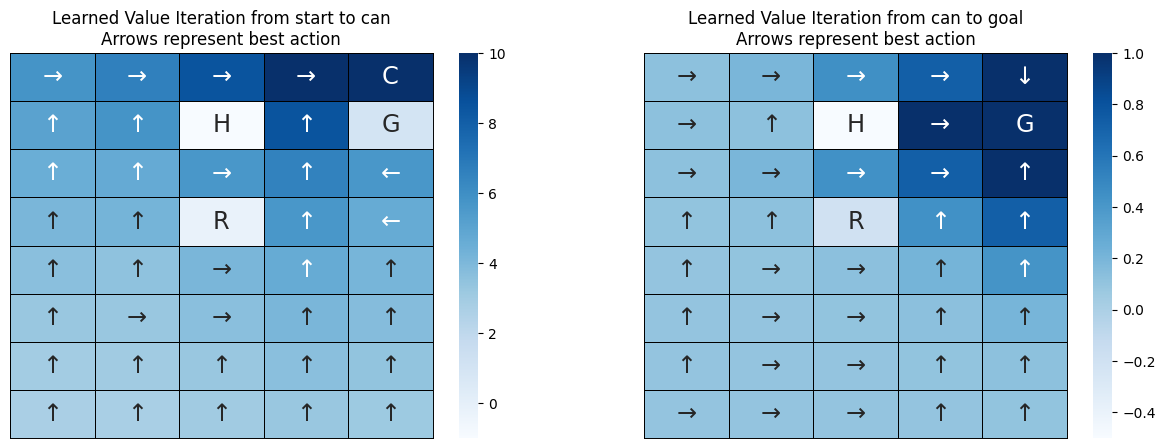

In [ ]:
#Policy call and plot

#define map
custom_map = [['F','F','F','F','C'], ['F','F','H','F','G'], ['F','F','F','F','F'], ['F','F','R','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['F','F','F','F','F'], ['S','F','F','F','F']]
map_out = np.array(custom_map)
print(map_out)

#call start to can
state_dict_can, V_can, move_direction_dict_can, value_policy_can, v_test_can, vtable_val_max_can, vtable_directions_can = eval_start_to_can_r4(custom_map)


#call can to goal
state_dict_goal, V_goal, move_direction_dict_goal, value_policy_goal, v_test_goal, vtable_val_max_goal, vtable_directions_goal = eval_can_to_goal_r4(custom_map)

print("Utility values from Start to Soda Can")
print(V_can.reshape((8,5)))

print('\nUtility values from Soda Can to Goal')
print(V_goal.reshape((8,5)))

problem_map = np.array(custom_map)
loc_start_annot = list(map(list, np.argwhere(problem_map == 'S')))[0]
loc_can_annot = list(map(list, np.argwhere(problem_map == 'C')))[0]
loc_goal_annot = list(map(list, np.argwhere(problem_map == 'G')))[0]
loc_hole_annot = list(map(list, np.argwhere(problem_map == 'H')))[0]
loc_rech_annot = list(map(list, np.argwhere(problem_map == 'R')))[0]

#vtable_directions_can[loc_start_annot[0], loc_start_annot[1]] = 'S'
vtable_directions_can[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_can[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_can[loc_hole_annot[0], loc_hole_annot[1]] = 'H'
vtable_directions_can[loc_rech_annot[0], loc_rech_annot[1]] = 'R'

# Plot the policy frame for can
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.heatmap(
    vtable_val_max_can,
    annot=vtable_directions_can,
    fmt="",
    ax=ax[0],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from start to can\nArrows represent best action")

for _, spine in ax[0].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")


#vtable_directions_goal[loc_start_annot[0], loc_start_annot[1]] = 'S'
#vtable_directions_goal[loc_can_annot[0], loc_can_annot[1]] = 'C'
vtable_directions_goal[loc_goal_annot[0], loc_goal_annot[1]] = 'G'
vtable_directions_goal[loc_hole_annot[0], loc_hole_annot[1]] = 'H'
vtable_directions_goal[loc_rech_annot[0], loc_rech_annot[1]] = 'R'

# Plot the policy frame for goal
sns.heatmap(
    vtable_val_max_goal,
    annot=vtable_directions_goal,
    fmt="",
    ax=ax[1],
    xticklabels=[],
    yticklabels=[],
    linecolor="black",
    linewidths=0.6,
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned Value Iteration from can to goal\nArrows represent best action")

for _, spine in ax[1].spines.items():
  spine.set_visible(True)
  spine.set_linewidth(0.7)
  spine.set_color("black")

plt.show()

In [ ]:
problem_map = np.array(custom_map)

loc_start = tuple(map(tuple, np.argwhere(problem_map == 'S')))
loc_can = tuple(map(tuple, np.argwhere(problem_map == 'C')))
loc_goal = tuple(map(tuple, np.argwhere(problem_map == 'G')))
loc_rech = tuple(map(tuple, np.argwhere(problem_map == 'R')))

start_pos = loc_start[0]
can_pos = loc_can[0]
goal_pos = loc_goal[0]
rech_pos = loc_rech[0]

print("start_pos: " + str(start_pos))
print("can_pos: " + str(can_pos))
print("goal_pos: " + str(goal_pos))
print("rech_pos: " + str(rech_pos))

num_episodes = 1
V_run_can = V_can.copy()
start_index = (start_pos[0]*matrix_size[1])+start_pos[1]
steps_req_manhattan = manhattan_distance(start_pos, can_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
steps_walked = run_episodes_start_to_can(state_dict_can, V_run_can, move_direction_dict_can, num_episodes, start_index, start_pos, value_policy_can, v_test_can)

print('\n------ Env reset, moving from soda can to goal')
print("Current Position: " + str(can_pos))
print("Goal Position: " + str(goal_pos))
V_run_goal = V_goal.copy()
can_index = (can_pos[0]*matrix_size[1])+can_pos[1]
steps_req_manhattan = manhattan_distance(can_pos, goal_pos)
print("steps required as per manhattan distance: " + str(steps_req_manhattan))
run_episodes_can_to_goal(state_dict_goal, V_run_goal, move_direction_dict_goal, num_episodes, can_index, can_pos, value_policy_goal, v_test_goal, steps_walked)

start_pos: (7, 0)
can_pos: (0, 4)
goal_pos: (1, 4)
rech_pos: (3, 2)
steps required as per manhattan distance: 11
starting from : (7, 0)
action taken: UP
next_state: 30;  current reward: 2.72060715342919;  completed: False;  total reward: 2.72060715342919;  steps: 1
action taken: UP
next_state: 25;  current reward: 2.9794501012833976;  completed: False;  total reward: 5.700057254712588;  steps: 2
action taken: UP
next_state: 20;  current reward: 3.28341321451477;  completed: False;  total reward: 8.983470469227358;  steps: 3
action taken: UP
next_state: 15;  current reward: 3.645858278847859;  completed: False;  total reward: 12.629328748075217;  steps: 4
action taken: UP
next_state: 10;  current reward: 4.073141326910289;  completed: False;  total reward: 16.702470074985506;  steps: 5
action taken: UP
next_state: 5;  current reward: 4.53642731495964;  completed: False;  total reward: 21.238897389945144;  steps: 6
action taken: UP
next_state: 0;  current reward: 5.0636143062826235;  com

### References:

Gymnasium:
https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/


MDP Frozen lake code provided in canvas modules

Value iteration algorithm and example from lecture slides